In [2]:
try:
    import google.colab
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Make use of a GPU or MPS (Apple) if one is available.  (see module 3.2)
import torch
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Note: not using Google CoLab
Using device: mps


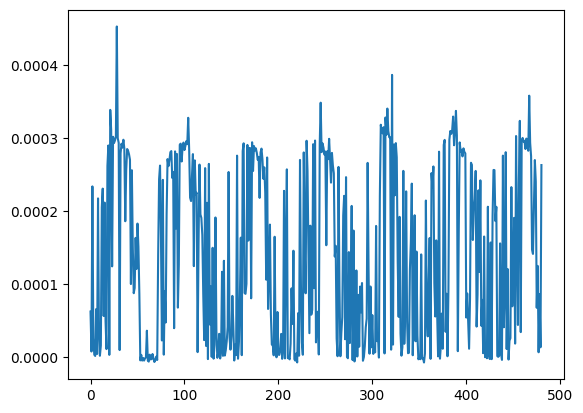

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

names = ['MSAVI_mean']
df = pd.read_csv(
    "dataset/tea_msavi_mean.csv")

# show the data on the graph 
import matplotlib.pyplot as plt
plt.plot(df['MSAVI_mean'])
plt.show()

In [4]:
# Data Preprocessing

df['MSAVI_mean'] = df['MSAVI_mean'].astype(float)
df_test = df.iloc[:300]
df_train = df.iloc[300:]

spots_train = df_train['MSAVI_mean'].to_numpy().reshape(-1, 1)
spots_test = df_test['MSAVI_mean'].to_numpy().reshape(-1, 1)

scaler = StandardScaler()
spots_train = scaler.fit_transform(spots_train).flatten().tolist()
spots_test = scaler.transform(spots_test).flatten().tolist()



Just like we did for LSTM in the previous section, we again break the data into sequences.

In [5]:
# Sequence Data Preparation
SEQUENCE_SIZE = 10

def to_sequences(seq_size, obs):
    x = []
    y = []
    for i in range(len(obs) - seq_size):
        window = obs[i:(i + seq_size)]
        after_window = obs[i + seq_size]
        x.append(window)
        y.append(after_window)
    return torch.tensor(x, dtype=torch.float32).view(-1, seq_size, 1), torch.tensor(y, dtype=torch.float32).view(-1, 1)

x_train, y_train = to_sequences(SEQUENCE_SIZE, spots_train)
x_test, y_test = to_sequences(SEQUENCE_SIZE, spots_test)

# Setup data loaders for batch
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [6]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [7]:
# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

model = TransformerModel().to(device)

/Users/jashvinuyeshwanth/Desktop/lag-llama/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [8]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

epochs = 1000
early_stop_count = 0
min_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 5:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")



/Users/jashvinuyeshwanth/Desktop/lag-llama/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/1000, Validation Loss: 2.0342
Epoch 2/1000, Validation Loss: 0.8717
Epoch 3/1000, Validation Loss: 0.7956
Epoch 4/1000, Validation Loss: 0.8380
Epoch 5/1000, Validation Loss: 0.7469
Epoch 6/1000, Validation Loss: 0.7277
Epoch 7/1000, Validation Loss: 0.7696
Epoch 8/1000, Validation Loss: 0.7473
Epoch 9/1000, Validation Loss: 0.7191
Epoch 10/1000, Validation Loss: 0.7192
Epoch 11/1000, Validation Loss: 0.7432
Epoch 12/1000, Validation Loss: 0.7428
Epoch 13/1000, Validation Loss: 0.7159
Epoch 14/1000, Validation Loss: 0.7702
Epoch 15/1000, Validation Loss: 0.7396
Epoch 16/1000, Validation Loss: 0.7033
Epoch 17/1000, Validation Loss: 0.7209
Epoch 18/1000, Validation Loss: 0.7374
Epoch 19/1000, Validation Loss: 0.7908
Epoch 20/1000, Validation Loss: 0.7410
Early stopping!


We can now evaluate the performance of this model.

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions.extend(outputs.squeeze().tolist())

# Convert predictions and y_test to original scale
predictions = scaler.inverse_transform(np.array(predictions).reshape(-2, 2))
y_test_orig = scaler.inverse_transform(y_test.numpy().reshape(-2, 2))

# Calculate errors
mae = mean_absolute_error(y_test_orig, predictions)
mse = mean_squared_error(y_test_orig, predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_orig - predictions) / y_test_orig)) * 100
r2 = r2_score(y_test_orig, predictions)

print(f"Score (MAE): {mae}")
print(f"Score (MSE): {mse}")
print(f"Score (RMSE): {rmse}")
print(f"Score (MAPE): {mape}")
print(f"Score (R²): {r2}")

Score (MAE): 9.332158464903707e-05
Score (MSE): 1.1074976540131623e-08
Score (RMSE): 0.00010523771443798854
Score (MAPE): 1991.6183264615472
Score (R²): 0.2005980783681967


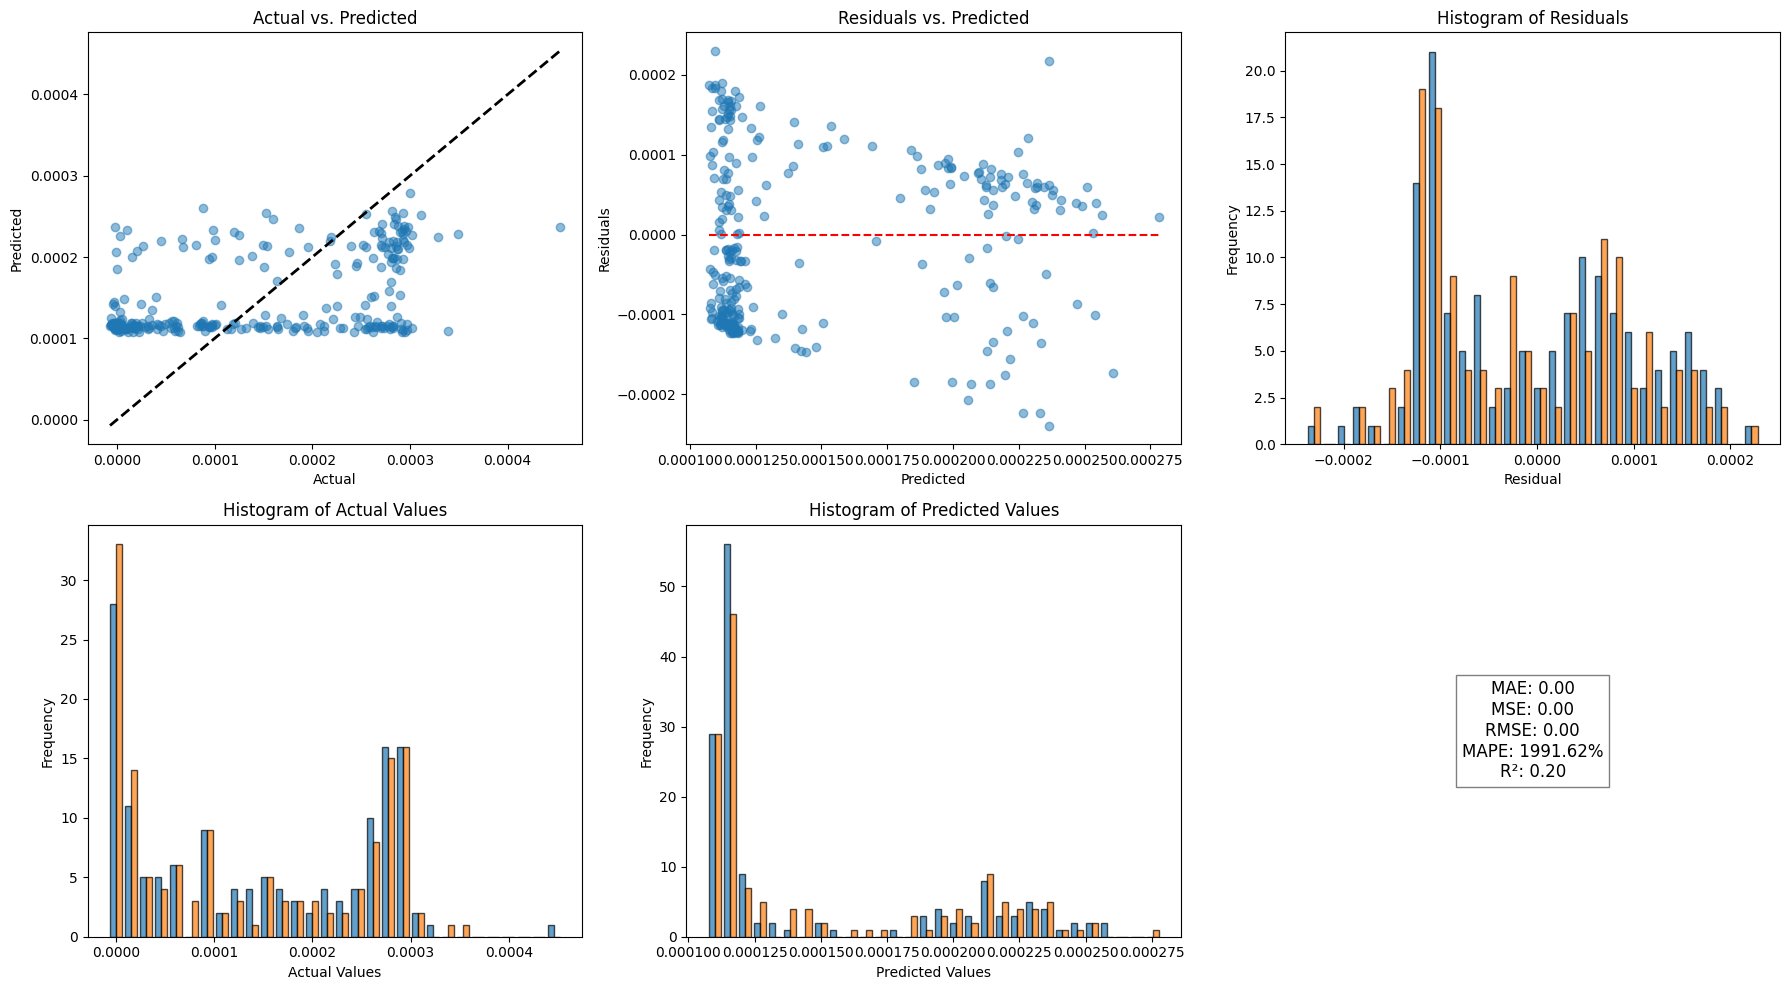

In [10]:
def plot_diagnostics(y_true, y_pred):
    residuals = y_true - y_pred
    
    plt.figure(figsize=(18, 10))

    # Plot 1: Actual vs. Predicted
    plt.subplot(2, 3, 1)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs. Predicted')

    # Plot 2: Residuals vs. Predicted
    plt.subplot(2, 3, 2)
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.hlines(0, y_pred.min(), y_pred.max(), colors='r', linestyles='dashed')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residuals vs. Predicted')

    # Plot 3: Histogram of Residuals
    plt.subplot(2, 3, 3)
    plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.title('Histogram of Residuals')

    # Plot 4: Histogram of Actual Values
    plt.subplot(2, 3, 4)
    plt.hist(y_true, bins=30, edgecolor='k', alpha=0.7)
    plt.xlabel('Actual Values')
    plt.ylabel('Frequency')
    plt.title('Histogram of Actual Values')

    # Plot 5: Histogram of Predicted Values
    plt.subplot(2, 3, 5)
    plt.hist(y_pred, bins=30, edgecolor='k', alpha=0.7)
    plt.xlabel('Predicted Values')
    plt.ylabel('Frequency')
    plt.title('Histogram of Predicted Values')

    # Plot 6: Metrics
    metrics_text = f'MAE: {mae:.2f}\nMSE: {mse:.2f}\nRMSE: {rmse:.2f}\nMAPE: {mape:.2f}%\nR²: {r2:.2f}'
    plt.subplot(2, 3, 6)
    plt.text(0.5, 0.5, metrics_text, fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_diagnostics(y_test_orig, predictions)


[[ 1.79339099e-06  1.58588355e-05]
 [ 2.05187636e-04  2.31023703e-04]
 [ 5.63377907e-05  2.11885359e-04]
 [ 4.92822728e-05  1.09325756e-05]
 [ 2.62229994e-04  2.90201249e-04]
 [ 3.01326349e-06  3.39005986e-04]
 [ 3.10960342e-04  1.24397397e-04]
 [ 3.02118424e-04  2.93550023e-04]
 [ 2.96957616e-04  3.02361004e-04]
 [ 4.53391636e-04  3.00169311e-04]
 [ 2.93732446e-04  9.60576108e-06]
 [ 2.79561849e-04  2.92612356e-04]
 [ 2.87184754e-04  2.98059254e-04]
 [ 2.86050257e-04  1.86295118e-04]
 [ 2.56306404e-04  2.85341404e-04]
 [ 2.82965979e-04  2.78047461e-04]
 [ 2.70624150e-04  1.00164900e-04]
 [ 2.56247615e-04  1.50715627e-04]
 [ 8.76031554e-05  9.47486042e-05]
 [ 1.63517252e-04  1.20790159e-04]
 [ 1.83088472e-04  1.51139684e-04]
 [ 8.62339293e-05 -4.49778008e-06]
 [ 3.01677051e-06 -4.81830057e-06]
 [-1.20421623e-06 -4.80190056e-06]
 [-1.82281815e-06 -5.15444924e-07]
 [ 3.61680359e-05 -4.87567877e-06]
 [-6.21398931e-06  3.29533782e-06]
 [-3.19794503e-06 -2.72896591e-06]
 [ 4.23389292e-06 -1

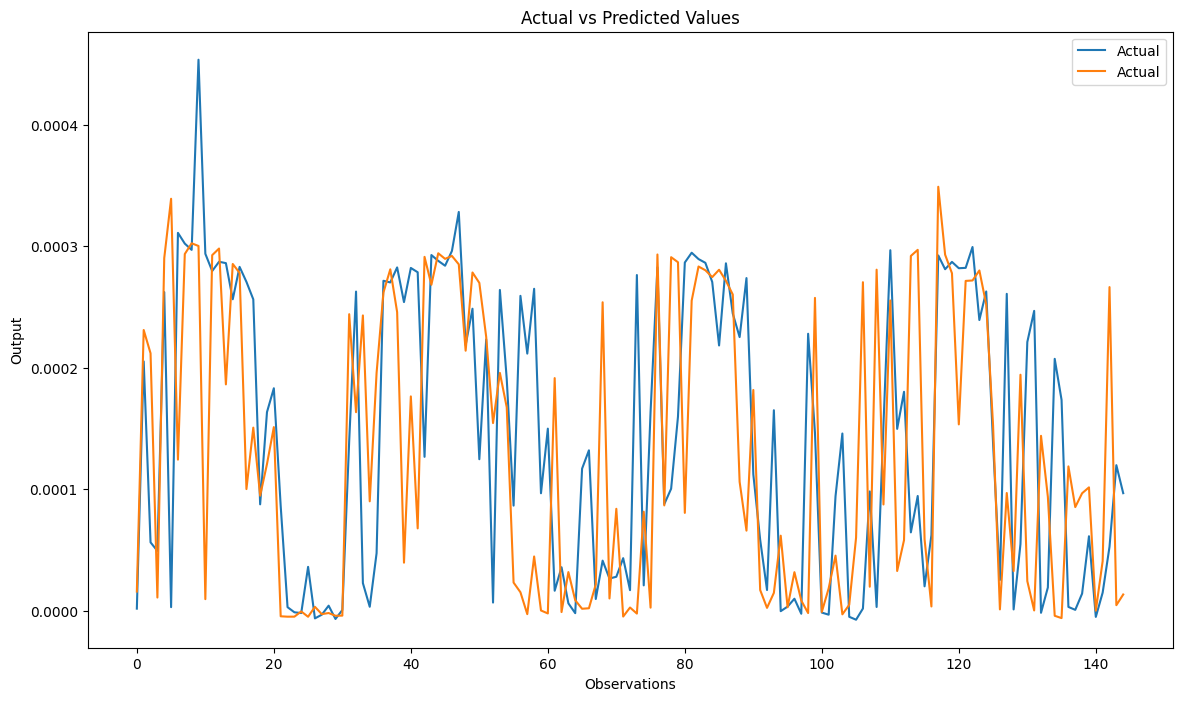

In [11]:
import matplotlib.pyplot as plt
print(y_test_orig)
# Plot actual vs predicted values
plt.figure(figsize=(14, 8))
plt.plot(y_test_orig, label='Actual')
#plt.plot(predictions, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Observations')
plt.ylabel('Output')
plt.legend()
plt.show()